<a href="https://colab.research.google.com/github/viniciusrpb/cic0269_natural_language_processing/blob/main/lectures/cap17_2_idmb_classification_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capítulo 17 - BERT

Para esse notebook Python, utilizaremos as classes Transformers do Hugging Face.

## 17.2 Classificação de reviews de filmes via BERT

Informações sobre o corpus IMDB Reviews, clique [aqui](https://www.tensorflow.org/datasets/catalog/imdb_reviews).



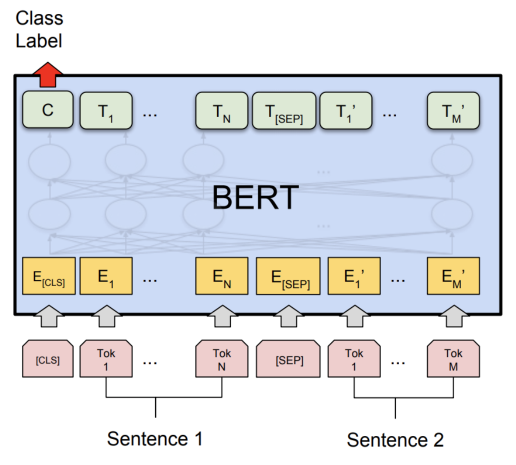

In [ ]:
!pip install tensorflow-datasets
!pip install keras
!pip install tensorflow
!pip install transformers

In [ ]:
from keras.models import Sequential,Model
from keras.layers import Dense,Embedding,,BatchNormalization,Input,LSTM,Bidirectional
from transformers import TFBertModel,BertTokenizer
from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import gensim
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
from tensorflow.keras.optimizers import Adam

In [ ]:
ds_train = tfds.load('imdb_reviews/plain_text', split='train', shuffle_files=True)
ds_test = tfds.load('imdb_reviews/plain_text', split='test', shuffle_files=False)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteHY52AR/imdb_reviews-train.tfrecord*...…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteHY52AR/imdb_reviews-test.tfrecord*...:…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteHY52AR/imdb_reviews-unsupervised.tfrec…

Dataset imdb_reviews downloaded and prepared to ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
df_train = tfds.as_dataframe(ds_train)
df_test = tfds.as_dataframe(ds_test)

In [ ]:
df_train.head()

,label,text
0,0,"b""This was an absolutely terrible movie. Don't..."
1,0,b'I have been known to fall asleep during film...
2,0,b'Mann photographs the Alberta Rocky Mountains...
3,1,b'This is the kind of film for a snowy Sunday ...
4,1,"b'As others have mentioned, all the women that..."


In [ ]:
def preprocessDataFrame(df):

    dic = {}
    dic['text'] = []
    dic['label'] = []

    review = [x.decode('utf-8') for x in df['text'].values]
    #class_label = [x.decode('utf-8') for x in df['label'].values]

    for idx,sentence in enumerate(review):
        dic['text'].append(review[idx])
        dic['label'].append(df['label'][idx])
        
    return pd.DataFrame.from_dict(dic)

In [ ]:
df_train = preprocessDataFrame(df_train)
df_test = preprocessDataFrame(df_test)

In [ ]:
df_train.head()

,text,label
0,This was an absolutely terrible movie. Don't b...,0
1,"I have been known to fall asleep during films,...",0
2,Mann photographs the Alberta Rocky Mountains i...,0
3,This is the kind of film for a snowy Sunday af...,1
4,"As others have mentioned, all the women that g...",1


In [ ]:
df_train['label'] = pd.Categorical(df_train['label'])
y_train_int = df_train['label'].cat.codes

df_test['label'] = pd.Categorical(df_test['label'])
y_test_int = df_test['label'].cat.codes

y_train = to_categorical(y_train_int)
y_test = to_categorical(y_test_int)

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
def sentence_bert_encode(df,tokenizer,max_len):

  input_ids = []
  attention_masks = []
  
  for i in range(len(df)):
      encoded = tokenizer.encode_plus(
        df[i],
        add_special_tokens=True,
        max_length=max_len,
        pad_to_max_length=True,
        return_attention_mask=True
      )
      
      input_ids.append(encoded['input_ids'])
      attention_masks.append(encoded['attention_mask'])

  return np.array(input_ids),np.array(attention_masks)

In [ ]:
max_sentence_length = 32

train_input_ids,train_attention_masks = sentence_bert_encode(df_train['text'],bert_tokenizer,max_sentence_length)
test_input_ids,test_attention_masks = sentence_bert_encode(df_test['text'],bert_tokenizer,max_sentence_length)

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
input_tokens = Input(shape=(max_sentence_length,),dtype="int64")
attention_masks = Input(shape=(max_sentence_length,),dtype="int64")

bert_model = TFBertModel.from_pretrained('bert-large-uncased')

embedding = bert_model([input_tokens,attention_masks])

output_layer = Dense(2, activation='softmax')(embedding[1])
model_bert = Model(inputs=[input_tokens,attention_masks], outputs=output_layer)

print(model_bert.summary())

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  335141888   ['input_3[0][0]',                
                                thPoolingAndCrossAt               'input_4[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 32,                                          

In [ ]:
adams_family = Adam(learning_rate=0.00001,decay=0.01)

model_bert.compile(optimizer = adams_family,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

history_fine = model_bert.fit([train_input_ids,train_attention_masks],y_train,
                              epochs=3,
                              batch_size=32,
                              validation_split=0.2)

Epoch 1/3
625/625 [==============================] - 489s 753ms/step - loss: 0.5371 - accuracy: 0.7167 - val_loss: 0.4730 - val_accuracy: 0.7602
Epoch 2/3
625/625 [==============================] - 468s 750ms/step - loss: 0.4573 - accuracy: 0.7732 - val_loss: 0.4671 - val_accuracy: 0.7692
Epoch 3/3
625/625 [==============================] - 470s 752ms/step - loss: 0.4352 - accuracy: 0.7903 - val_loss: 0.4600 - val_accuracy: 0.7710


In [ ]:
y_prob = model_bert.predict([test_input_ids,test_attention_masks])
y_pred = np.argmax(y_prob,axis=1)
print(classification_report(y_test_int, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.76      0.77     12500
           1       0.76      0.79      0.77     12500

    accuracy                           0.77     25000
   macro avg       0.77      0.77      0.77     25000
weighted avg       0.77      0.77      0.77     25000

